## Importing Required modules

In [19]:
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier as CBC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier as XGB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score as ruc
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)
import seaborn as sns
from scipy import stats
from scipy.stats import norm

### Loading Datasets

In [20]:
# Load datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

### Handling missing data

In [21]:
all_data = train.append(test)
all_data.reset_index(inplace=True)
all_data.drop('index',inplace=True,axis=1)

In [ ]:
print ('The train data has {0} rows and {1} columns'.format(train.shape[0],train.shape[1]))
print ('----------------------------')
print ('The test data has {0} rows and {1} columns'.format(test.shape[0],test.shape[1]))
miss = test.isnull().sum()/len(train)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

In [ ]:
#visualising missing values
miss = miss.to_frame()
miss.columns = ['count']
miss.index.names = ['Name']
miss['Name'] = miss.index

#plot the missing value count
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Name', y = 'count', data=miss)
plt.xticks(rotation = 90)
sns.plt.show()

In [22]:
# handling missing data
all_data['Fare'].fillna(all_data['Fare'].median(), inplace=True)

all_data['Cabin'].fillna("None",inplace=True)
all_data['Has_Age'] = (all_data['Age'].notnull())*1

In [23]:
age_avg = all_data['Age'].mean()
age_std = all_data['Age'].std()
age_null_count = all_data['Age'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
all_data['Age'][np.isnan(all_data['Age'])] = age_null_random_list
all_data['Age'] = all_data['Age'].astype(int)

### Analysing Data

In [24]:
train_0 = pd.DataFrame(all_data[all_data['Survived']==0])
train_0.drop('Survived',axis=1,inplace=True)
train_1 = pd.DataFrame(all_data[all_data['Survived']==1])
train_1.drop('Survived',axis=1,inplace=True)

In [ ]:
sns.countplot(x="Sex", data=train_0, palette="Greens_d")

### Feature Engineering

In [25]:
def title(name):
    return name.split(' ')[1][:-1]

def surname(name):
    return name.split(' ')[0][:-1]

def ticket_num(x):
    x = x.split(' ')
    if x[0].isdigit():
        return x[0]
    if len(x)>1:
        return x[1]

def ticket_type(x):
    x = x.split(' ')
    if x[0].isdigit():
        return "None"
    return x[0]

all_data['Title'] = all_data['Name'].map(lambda x: title(x))
all_data['Title'].replace({'':'None'},inplace=True)
all_data['Name_length'] = all_data['Name'].apply(len)
all_data['Family_Size'] = all_data['SibSp']+all_data['Parch']+1
all_data['Age*Class']=all_data['Age']*all_data['Pclass']
all_data['Deck']=all_data['Cabin'].map(lambda x: x[0])
all_data['Fare_Per_Person']=all_data['Fare']/(all_data['Family_Size'])
all_data['Surname'] = all_data['Name'].apply(lambda x: surname(x))
all_data['Age_Bins'] = pd.cut(all_data['Age'], 5,labels=[0,1,2,3,4])
all_data['Embarked'] = all_data['Embarked'].fillna('S')
all_data['Has_Cabin'] = all_data['Cabin'].map(lambda x: (x!='None')*1)  
all_data['is_alone'] = (all_data['Family_Size']==1)*1
all_data['Ticket_num'] = all_data['Ticket'].map(lambda x: ticket_num(x))
all_data['Ticket_num'] = all_data['Ticket_num'].replace({'Basle':0,'2.':2}).fillna(0).astype(object)
all_data['Ticket_type'] = all_data['Ticket'].map(lambda x: ticket_type(x))
all_data['CategoricalFare'] = pd.qcut(all_data['Fare'], 4,labels=[0,1,2,3])
all_data.loc[ all_data['Fare'] <= 7.91, 'Fare'] = 0
all_data.loc[(all_data['Fare'] > 7.91) & (all_data['Fare'] <= 14.454), 'Fare'] = 1
all_data.loc[(all_data['Fare'] > 14.454) & (all_data['Fare'] <= 31), 'Fare']   = 2
all_data.loc[ all_data['Fare'] > 31, 'Fare'] = 3
all_data.loc[ all_data['Age'] <= 16, 'Age']= 0
all_data.loc[(all_data['Age'] > 16) & (all_data['Age'] <= 32), 'Age'] = 1
all_data.loc[(all_data['Age'] > 32) & (all_data['Age'] <= 48), 'Age'] = 2
all_data.loc[(all_data['Age'] > 48) & (all_data['Age'] <= 64), 'Age'] = 3
all_data.loc[ all_data['Age'] > 64, 'Age'] = 4
all_data['Title'] = all_data['Title'].replace(['Planke', 'Don', 'Rev', 'Billiard',
       'de', 'Walle', 'Dr', 'Pelsmaeker', 'Mulder', 'None', 'Steen',
       'Carlo', 'Impe', 'Major', 'Gordon', 'Messemaeker',
        'Col', 'Capt', 'Velde', 'th', 'Shawah', 'Jonkheer',
       'Melkebeke', 'Cruyssen', 'Khalil', 'Palmquist', 'Brito'],'Rare')
all_data['Title'] = all_data['Title'].replace('Mlle', 'Miss')
all_data['Title'] = all_data['Title'].replace('Ms', 'Miss')
all_data['Title'] = all_data['Title'].replace('Mme', 'Mrs')

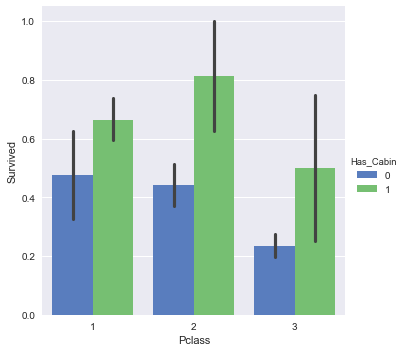

In [26]:
sns.factorplot(x="Pclass", y="Survived", hue="Has_Cabin", data=all_data[all_data['Survived'].notnull()],
                   size=5, kind="bar", palette="muted")

In [27]:
pd.crosstab(all_data['Title'], all_data['Sex'])

Sex,female,male
Title,,
Master,0,59
Miss,260,0
Mr,0,736
Mrs,192,0
Rare,14,48


The skewness of SalePrice is -0.012185502755794357


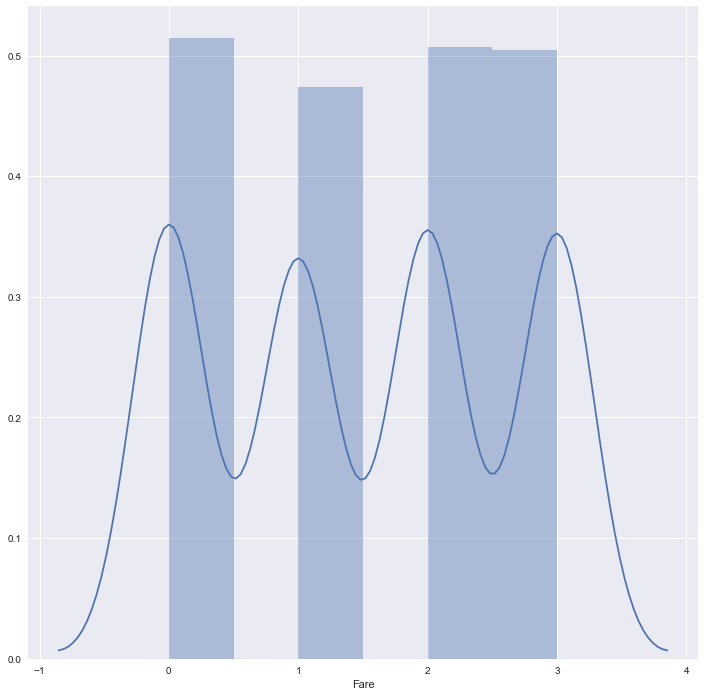

In [28]:
sns.distplot(all_data['Fare'])
print("The skewness of SalePrice is {}".format(all_data['Fare'].skew()))

### Separating Datasets

In [29]:
train = all_data[all_data['Survived'].notnull()]
test = all_data[all_data['Survived'].isnull()]

In [30]:
#separate variables into new data frames
numeric_data = train.select_dtypes(include=[np.number])
cat_data = train.select_dtypes(exclude=[np.number])
print("There are {} numeric and {} categorical columns in train data".format(numeric_data.shape[1],cat_data.shape[1]))

There are 14 numeric and 12 categorical columns in train data


### Heatmaps and Anova

is_alone           1.000000
Age*Class          0.283300
Age                0.168197
Pclass             0.135207
PassengerId        0.057462
Fare_Per_Person    0.045603
Has_Age           -0.151319
Has_Cabin         -0.158029
Survived          -0.203367
Name_length       -0.406800
Fare              -0.568942
Parch             -0.583398
SibSp             -0.584471
Family_Size       -0.690922
Name: is_alone, dtype: float64


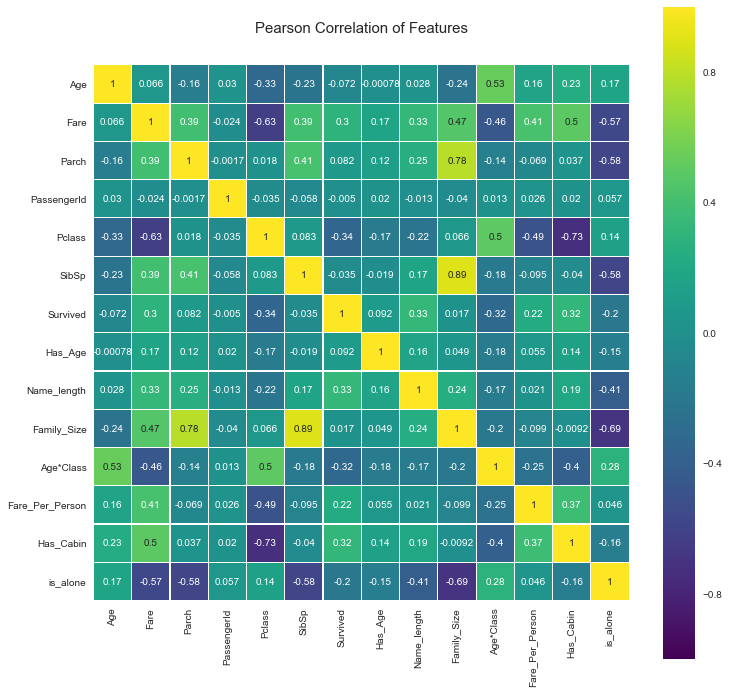

In [31]:
corr = numeric_data.corr()
print(corr['is_alone'].sort_values(ascending=False))
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(corr,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

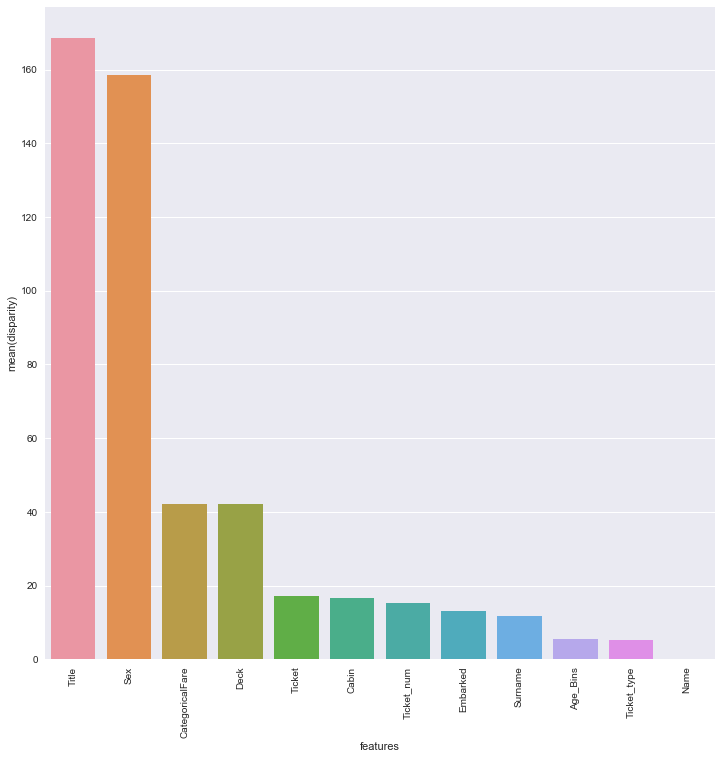

In [32]:
cat = cat_data.columns
def anova(frame):
    anv = pd.DataFrame()
    anv['features'] = cat
    pvals = []
    for c in cat:
           samples = []
           for cls in frame[c].unique():
                  s = frame[frame[c] == cls]['Survived'].values
                  samples.append(s)
           pval = stats.f_oneway(*samples)[1]
           pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

cat_data['Survived'] = train.Survived.values
k = anova(cat_data) 
k['disparity'] = np.log(1./k['pval'].values) 
sns.barplot(data=k, x = 'features', y='disparity')
plt.xticks(rotation=90) 
plt 

## Training Models

In [33]:
cols = list(train.columns)
cols.remove('Survived')
cols.remove('PassengerId')
cols.remove('Name')
cols.remove('Cabin')
cols.remove('Ticket')
train['Survived'] = train['Survived'].astype(int)

### CatBoost

In [34]:
X_train,X_test,y_train,y_test = train_test_split(train[cols],train['Survived'],random_state=0)
positive = len(y_train[y_train==1])
negative = len(y_train)-positive
ratio = negative/positive
print(negative,positive,ratio,X_train.columns)

410 258 1.5891472868217054 Index(['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Has_Age',
       'Title', 'Name_length', 'Family_Size', 'Age*Class', 'Deck',
       'Fare_Per_Person', 'Surname', 'Age_Bins', 'Has_Cabin', 'is_alone',
       'Ticket_num', 'Ticket_type', 'CategoricalFare'],
      dtype='object')


In [36]:
model = CBC(depth=4,iterations=2000,learning_rate=0.006,od_pval=0.001,eval_metric='Accuracy',random_seed=0)
model.fit(X_train
          ,y_train
          ,cat_features=[1,4,5,7,8,12,14,15,16,17,18,19,20]
          ,eval_set = (X_test, y_test)
          ,use_best_model=True
          ,verbose=True)

Borders generated
0:	learn 0.8083832335	test 0.7623318386	bestTest 0.7623318386	passed: 0.023 sec	total: 125ms	remaining: 4m 9s
1:	learn 0.8098802395	test 0.7623318386	bestTest 0.7623318386	passed: 0.018 sec	total: 143ms	remaining: 2m 23s
2:	learn 0.8158682635	test 0.798206278	bestTest 0.798206278	passed: 0.0256 sec	total: 169ms	remaining: 1m 52s
3:	learn 0.8068862275	test 0.7937219731	bestTest 0.798206278	passed: 0.0175 sec	total: 187ms	remaining: 1m 33s
4:	learn 0.8188622754	test 0.7892376682	bestTest 0.798206278	passed: 0.0199 sec	total: 207ms	remaining: 1m 22s
5:	learn 0.8188622754	test 0.798206278	bestTest 0.798206278	passed: 0.0186 sec	total: 226ms	remaining: 1m 15s
6:	learn 0.8173652695	test 0.7892376682	bestTest 0.798206278	passed: 0.0159 sec	total: 242ms	remaining: 1m 8s
7:	learn 0.8203592814	test 0.8071748879	bestTest 0.8071748879	passed: 0.0172 sec	total: 259ms	remaining: 1m 4s
8:	learn 0.8188622754	test 0.802690583	bestTest 0.8071748879	passed: 0.0155 sec	total: 275ms	remai

79:	learn 0.8308383234	test 0.8161434978	bestTest 0.8161434978	passed: 0.0239 sec	total: 2.25s	remaining: 54s
80:	learn 0.8308383234	test 0.8161434978	bestTest 0.8161434978	passed: 0.04 sec	total: 2.3s	remaining: 54.4s
81:	learn 0.8293413174	test 0.8116591928	bestTest 0.8161434978	passed: 0.0608 sec	total: 2.36s	remaining: 55.2s
82:	learn 0.8293413174	test 0.8116591928	bestTest 0.8161434978	passed: 0.0192 sec	total: 2.38s	remaining: 54.9s
83:	learn 0.8293413174	test 0.8116591928	bestTest 0.8161434978	passed: 0.0291 sec	total: 2.41s	remaining: 55s
84:	learn 0.8293413174	test 0.8116591928	bestTest 0.8161434978	passed: 0.0183 sec	total: 2.43s	remaining: 54.7s
85:	learn 0.8293413174	test 0.8116591928	bestTest 0.8161434978	passed: 0.0491 sec	total: 2.48s	remaining: 55.1s
86:	learn 0.8293413174	test 0.8116591928	bestTest 0.8161434978	passed: 0.0482 sec	total: 2.53s	remaining: 55.5s
87:	learn 0.8293413174	test 0.8116591928	bestTest 0.8161434978	passed: 0.0433 sec	total: 2.57s	remaining: 55.8s

159:	learn 0.8308383234	test 0.8116591928	bestTest 0.8206278027	passed: 0.0302 sec	total: 3.99s	remaining: 45.9s
160:	learn 0.8323353293	test 0.8116591928	bestTest 0.8206278027	passed: 0.0278 sec	total: 4.02s	remaining: 45.9s
161:	learn 0.8323353293	test 0.8116591928	bestTest 0.8206278027	passed: 0.0241 sec	total: 4.05s	remaining: 45.9s
162:	learn 0.8323353293	test 0.8116591928	bestTest 0.8206278027	passed: 0.0214 sec	total: 4.07s	remaining: 45.9s
163:	learn 0.8323353293	test 0.8116591928	bestTest 0.8206278027	passed: 0.0193 sec	total: 4.09s	remaining: 45.8s
164:	learn 0.8323353293	test 0.8161434978	bestTest 0.8206278027	passed: 0.0167 sec	total: 4.11s	remaining: 45.7s
165:	learn 0.8323353293	test 0.8161434978	bestTest 0.8206278027	passed: 0.0184 sec	total: 4.12s	remaining: 45.6s
166:	learn 0.8323353293	test 0.8161434978	bestTest 0.8206278027	passed: 0.00645 sec	total: 4.13s	remaining: 45.3s
167:	learn 0.8323353293	test 0.8161434978	bestTest 0.8206278027	passed: 0.0195 sec	total: 4.15s

233:	learn 0.8338323353	test 0.8251121076	bestTest 0.8251121076	passed: 0.0257 sec	total: 5.5s	remaining: 41.5s
234:	learn 0.8338323353	test 0.8251121076	bestTest 0.8251121076	passed: 0.0309 sec	total: 5.53s	remaining: 41.5s
235:	learn 0.8338323353	test 0.8251121076	bestTest 0.8251121076	passed: 0.0257 sec	total: 5.55s	remaining: 41.5s
236:	learn 0.8353293413	test 0.8251121076	bestTest 0.8251121076	passed: 0.0169 sec	total: 5.57s	remaining: 41.5s
237:	learn 0.8338323353	test 0.8251121076	bestTest 0.8251121076	passed: 0.0219 sec	total: 5.59s	remaining: 41.4s
238:	learn 0.8353293413	test 0.8251121076	bestTest 0.8251121076	passed: 0.0221 sec	total: 5.62s	remaining: 41.4s
239:	learn 0.8338323353	test 0.8251121076	bestTest 0.8251121076	passed: 0.0179 sec	total: 5.64s	remaining: 41.3s
240:	learn 0.8338323353	test 0.8251121076	bestTest 0.8251121076	passed: 0.0183 sec	total: 5.66s	remaining: 41.3s
241:	learn 0.8353293413	test 0.8251121076	bestTest 0.8251121076	passed: 0.0201 sec	total: 5.67s	r

316:	learn 0.8368263473	test 0.8340807175	bestTest 0.8340807175	passed: 0.0275 sec	total: 7.2s	remaining: 38.3s
317:	learn 0.8368263473	test 0.8340807175	bestTest 0.8340807175	passed: 0.0251 sec	total: 7.23s	remaining: 38.2s
318:	learn 0.8368263473	test 0.8340807175	bestTest 0.8340807175	passed: 0.0232 sec	total: 7.25s	remaining: 38.2s
319:	learn 0.8368263473	test 0.8340807175	bestTest 0.8340807175	passed: 0.0172 sec	total: 7.27s	remaining: 38.2s
320:	learn 0.8368263473	test 0.8340807175	bestTest 0.8340807175	passed: 0.0197 sec	total: 7.29s	remaining: 38.1s
321:	learn 0.8368263473	test 0.8340807175	bestTest 0.8340807175	passed: 0.0167 sec	total: 7.31s	remaining: 38.1s
322:	learn 0.8368263473	test 0.8340807175	bestTest 0.8340807175	passed: 0.0187 sec	total: 7.33s	remaining: 38s
323:	learn 0.8368263473	test 0.8340807175	bestTest 0.8340807175	passed: 0.0104 sec	total: 7.34s	remaining: 38s
324:	learn 0.8368263473	test 0.8340807175	bestTest 0.8340807175	passed: 0.0181 sec	total: 7.36s	remai

390:	learn 0.8368263473	test 0.8340807175	bestTest 0.8385650224	passed: 0.0264 sec	total: 8.72s	remaining: 35.9s
391:	learn 0.8368263473	test 0.8340807175	bestTest 0.8385650224	passed: 0.00796 sec	total: 8.73s	remaining: 35.8s
392:	learn 0.8368263473	test 0.8340807175	bestTest 0.8385650224	passed: 0.0258 sec	total: 8.76s	remaining: 35.8s
393:	learn 0.8368263473	test 0.8340807175	bestTest 0.8385650224	passed: 0.0169 sec	total: 8.77s	remaining: 35.8s
394:	learn 0.8368263473	test 0.8340807175	bestTest 0.8385650224	passed: 0.0185 sec	total: 8.79s	remaining: 35.7s
395:	learn 0.8368263473	test 0.8340807175	bestTest 0.8385650224	passed: 0.0143 sec	total: 8.81s	remaining: 35.7s
396:	learn 0.8368263473	test 0.8385650224	bestTest 0.8385650224	passed: 0.00647 sec	total: 8.81s	remaining: 35.6s
397:	learn 0.8368263473	test 0.8385650224	bestTest 0.8385650224	passed: 0.0207 sec	total: 8.84s	remaining: 35.6s
398:	learn 0.8368263473	test 0.8385650224	bestTest 0.8385650224	passed: 0.018 sec	total: 8.85s

470:	learn 0.8398203593	test 0.8295964126	bestTest 0.8385650224	passed: 0.0188 sec	total: 10.2s	remaining: 33.2s
471:	learn 0.8398203593	test 0.8295964126	bestTest 0.8385650224	passed: 0.0285 sec	total: 10.3s	remaining: 33.2s
472:	learn 0.8398203593	test 0.8295964126	bestTest 0.8385650224	passed: 0.012 sec	total: 10.3s	remaining: 33.2s
473:	learn 0.8398203593	test 0.8295964126	bestTest 0.8385650224	passed: 0.0271 sec	total: 10.3s	remaining: 33.2s
474:	learn 0.8398203593	test 0.8295964126	bestTest 0.8385650224	passed: 0.017 sec	total: 10.3s	remaining: 33.1s
475:	learn 0.8398203593	test 0.8295964126	bestTest 0.8385650224	passed: 0.0146 sec	total: 10.3s	remaining: 33.1s
476:	learn 0.8398203593	test 0.8295964126	bestTest 0.8385650224	passed: 0.0155 sec	total: 10.3s	remaining: 33s
477:	learn 0.8413173653	test 0.8295964126	bestTest 0.8385650224	passed: 0.0175 sec	total: 10.4s	remaining: 33s
478:	learn 0.8413173653	test 0.8295964126	bestTest 0.8385650224	passed: 0.0246 sec	total: 10.4s	remain

544:	learn 0.8413173653	test 0.8295964126	bestTest 0.8385650224	passed: 0.0325 sec	total: 12.2s	remaining: 32.6s
545:	learn 0.8413173653	test 0.8295964126	bestTest 0.8385650224	passed: 0.0413 sec	total: 12.3s	remaining: 32.6s
546:	learn 0.8413173653	test 0.8251121076	bestTest 0.8385650224	passed: 0.0371 sec	total: 12.3s	remaining: 32.7s
547:	learn 0.8413173653	test 0.8251121076	bestTest 0.8385650224	passed: 0.0223 sec	total: 12.3s	remaining: 32.6s
548:	learn 0.8413173653	test 0.8251121076	bestTest 0.8385650224	passed: 0.0205 sec	total: 12.3s	remaining: 32.6s
549:	learn 0.8428143713	test 0.8251121076	bestTest 0.8385650224	passed: 0.0164 sec	total: 12.4s	remaining: 32.6s
550:	learn 0.8428143713	test 0.8251121076	bestTest 0.8385650224	passed: 0.0127 sec	total: 12.4s	remaining: 32.5s
551:	learn 0.8428143713	test 0.8251121076	bestTest 0.8385650224	passed: 0.0204 sec	total: 12.4s	remaining: 32.5s
552:	learn 0.8428143713	test 0.8251121076	bestTest 0.8385650224	passed: 0.0164 sec	total: 12.4s	

625:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0259 sec	total: 13.9s	remaining: 30.5s
626:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0303 sec	total: 13.9s	remaining: 30.5s
627:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.017 sec	total: 13.9s	remaining: 30.5s
628:	learn 0.8473053892	test 0.8251121076	bestTest 0.8385650224	passed: 0.0179 sec	total: 14s	remaining: 30.4s
629:	learn 0.8473053892	test 0.8251121076	bestTest 0.8385650224	passed: 0.0176 sec	total: 14s	remaining: 30.4s
630:	learn 0.8473053892	test 0.8251121076	bestTest 0.8385650224	passed: 0.0192 sec	total: 14s	remaining: 30.4s
631:	learn 0.8473053892	test 0.8251121076	bestTest 0.8385650224	passed: 0.0169 sec	total: 14s	remaining: 30.3s
632:	learn 0.8473053892	test 0.8251121076	bestTest 0.8385650224	passed: 0.021 sec	total: 14s	remaining: 30.3s
633:	learn 0.8473053892	test 0.8251121076	bestTest 0.8385650224	passed: 0.0211 sec	total: 14.1s	remaining: 3

702:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0197 sec	total: 15.4s	remaining: 28.4s
703:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0258 sec	total: 15.4s	remaining: 28.4s
704:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0213 sec	total: 15.5s	remaining: 28.4s
705:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0214 sec	total: 15.5s	remaining: 28.4s
706:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0203 sec	total: 15.5s	remaining: 28.4s
707:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0222 sec	total: 15.5s	remaining: 28.3s
708:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0185 sec	total: 15.5s	remaining: 28.3s
709:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0117 sec	total: 15.6s	remaining: 28.3s
710:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0173 sec	total: 15.6s	

777:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0225 sec	total: 16.9s	remaining: 26.5s
778:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0347 sec	total: 16.9s	remaining: 26.5s
779:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.013 sec	total: 16.9s	remaining: 26.5s
780:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0208 sec	total: 17s	remaining: 26.5s
781:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0198 sec	total: 17s	remaining: 26.5s
782:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.021 sec	total: 17s	remaining: 26.4s
783:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0158 sec	total: 17s	remaining: 26.4s
784:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.00976 sec	total: 17s	remaining: 26.4s
785:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0217 sec	total: 17.1s	remaining: 

855:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0299 sec	total: 18.4s	remaining: 24.6s
856:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0124 sec	total: 18.4s	remaining: 24.6s
857:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0217 sec	total: 18.5s	remaining: 24.6s
858:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0173 sec	total: 18.5s	remaining: 24.6s
859:	learn 0.8488023952	test 0.8251121076	bestTest 0.8385650224	passed: 0.0174 sec	total: 18.5s	remaining: 24.5s
860:	learn 0.8502994012	test 0.8251121076	bestTest 0.8385650224	passed: 0.0205 sec	total: 18.5s	remaining: 24.5s
861:	learn 0.8502994012	test 0.8251121076	bestTest 0.8385650224	passed: 0.0177 sec	total: 18.5s	remaining: 24.5s
862:	learn 0.8502994012	test 0.8251121076	bestTest 0.8385650224	passed: 0.0192 sec	total: 18.6s	remaining: 24.5s
863:	learn 0.8502994012	test 0.8251121076	bestTest 0.8385650224	passed: 0.016 sec	total: 18.6s	r

931:	learn 0.8532934132	test 0.8251121076	bestTest 0.8385650224	passed: 0.0271 sec	total: 19.9s	remaining: 22.8s
932:	learn 0.8517964072	test 0.8251121076	bestTest 0.8385650224	passed: 0.0231 sec	total: 19.9s	remaining: 22.8s
933:	learn 0.8517964072	test 0.8251121076	bestTest 0.8385650224	passed: 0.023 sec	total: 20s	remaining: 22.8s
934:	learn 0.8532934132	test 0.8251121076	bestTest 0.8385650224	passed: 0.0171 sec	total: 20s	remaining: 22.8s
935:	learn 0.8532934132	test 0.8251121076	bestTest 0.8385650224	passed: 0.0204 sec	total: 20s	remaining: 22.7s
936:	learn 0.8532934132	test 0.8251121076	bestTest 0.8385650224	passed: 0.0177 sec	total: 20s	remaining: 22.7s
937:	learn 0.8532934132	test 0.8251121076	bestTest 0.8385650224	passed: 0.0172 sec	total: 20s	remaining: 22.7s
938:	learn 0.8532934132	test 0.8251121076	bestTest 0.8385650224	passed: 0.0178 sec	total: 20.1s	remaining: 22.7s
939:	learn 0.8532934132	test 0.8251121076	bestTest 0.8385650224	passed: 0.0164 sec	total: 20.1s	remaining: 

1006:	learn 0.8532934132	test 0.8251121076	bestTest 0.8385650224	passed: 0.0285 sec	total: 21.9s	remaining: 21.6s
1007:	learn 0.8532934132	test 0.8251121076	bestTest 0.8385650224	passed: 0.046 sec	total: 21.9s	remaining: 21.6s
1008:	learn 0.8532934132	test 0.8251121076	bestTest 0.8385650224	passed: 0.0255 sec	total: 22s	remaining: 21.6s
1009:	learn 0.8532934132	test 0.8251121076	bestTest 0.8385650224	passed: 0.0382 sec	total: 22s	remaining: 21.6s
1010:	learn 0.8532934132	test 0.8251121076	bestTest 0.8385650224	passed: 0.0202 sec	total: 22s	remaining: 21.6s
1011:	learn 0.8532934132	test 0.8251121076	bestTest 0.8385650224	passed: 0.0343 sec	total: 22.1s	remaining: 21.5s
1012:	learn 0.8532934132	test 0.8251121076	bestTest 0.8385650224	passed: 0.0247 sec	total: 22.1s	remaining: 21.5s
1013:	learn 0.8532934132	test 0.8251121076	bestTest 0.8385650224	passed: 0.0307 sec	total: 22.1s	remaining: 21.5s
1014:	learn 0.8532934132	test 0.8251121076	bestTest 0.8385650224	passed: 0.0278 sec	total: 22.1

1088:	learn 0.8562874251	test 0.8251121076	bestTest 0.8385650224	passed: 0.0147 sec	total: 23.6s	remaining: 19.8s
1089:	learn 0.8562874251	test 0.8251121076	bestTest 0.8385650224	passed: 0.0262 sec	total: 23.6s	remaining: 19.7s
1090:	learn 0.8562874251	test 0.8251121076	bestTest 0.8385650224	passed: 0.0247 sec	total: 23.7s	remaining: 19.7s
1091:	learn 0.8562874251	test 0.8251121076	bestTest 0.8385650224	passed: 0.0183 sec	total: 23.7s	remaining: 19.7s
1092:	learn 0.8562874251	test 0.8251121076	bestTest 0.8385650224	passed: 0.0211 sec	total: 23.7s	remaining: 19.7s
1093:	learn 0.8562874251	test 0.8251121076	bestTest 0.8385650224	passed: 0.0174 sec	total: 23.7s	remaining: 19.7s
1094:	learn 0.8562874251	test 0.8251121076	bestTest 0.8385650224	passed: 0.0571 sec	total: 23.8s	remaining: 19.7s
1095:	learn 0.8562874251	test 0.8251121076	bestTest 0.8385650224	passed: 0.017 sec	total: 23.8s	remaining: 19.6s
1096:	learn 0.8562874251	test 0.8251121076	bestTest 0.8385650224	passed: 0.0221 sec	total

1161:	learn 0.8577844311	test 0.8295964126	bestTest 0.8385650224	passed: 0.0925 sec	total: 25.2s	remaining: 18.2s
1162:	learn 0.8577844311	test 0.8295964126	bestTest 0.8385650224	passed: 0.0238 sec	total: 25.2s	remaining: 18.2s
1163:	learn 0.8577844311	test 0.8295964126	bestTest 0.8385650224	passed: 0.0189 sec	total: 25.2s	remaining: 18.1s
1164:	learn 0.8577844311	test 0.8295964126	bestTest 0.8385650224	passed: 0.0201 sec	total: 25.3s	remaining: 18.1s
1165:	learn 0.8577844311	test 0.8295964126	bestTest 0.8385650224	passed: 0.0177 sec	total: 25.3s	remaining: 18.1s
1166:	learn 0.8577844311	test 0.8295964126	bestTest 0.8385650224	passed: 0.0179 sec	total: 25.3s	remaining: 18.1s
1167:	learn 0.8577844311	test 0.8295964126	bestTest 0.8385650224	passed: 0.0168 sec	total: 25.3s	remaining: 18s
1168:	learn 0.8577844311	test 0.8295964126	bestTest 0.8385650224	passed: 0.0196 sec	total: 25.3s	remaining: 18s
1169:	learn 0.8577844311	test 0.8295964126	bestTest 0.8385650224	passed: 0.0186 sec	total: 2

1242:	learn 0.8607784431	test 0.8295964126	bestTest 0.8385650224	passed: 0.0179 sec	total: 26.9s	remaining: 16.4s
1243:	learn 0.8607784431	test 0.8295964126	bestTest 0.8385650224	passed: 0.0311 sec	total: 26.9s	remaining: 16.4s
1244:	learn 0.8607784431	test 0.8295964126	bestTest 0.8385650224	passed: 0.0263 sec	total: 26.9s	remaining: 16.3s
1245:	learn 0.8607784431	test 0.8295964126	bestTest 0.8385650224	passed: 0.0177 sec	total: 27s	remaining: 16.3s
1246:	learn 0.8607784431	test 0.8295964126	bestTest 0.8385650224	passed: 0.0183 sec	total: 27s	remaining: 16.3s
1247:	learn 0.8607784431	test 0.8295964126	bestTest 0.8385650224	passed: 0.0168 sec	total: 27s	remaining: 16.3s
1248:	learn 0.8607784431	test 0.8295964126	bestTest 0.8385650224	passed: 0.016 sec	total: 27s	remaining: 16.2s
1249:	learn 0.8607784431	test 0.8295964126	bestTest 0.8385650224	passed: 0.0181 sec	total: 27s	remaining: 16.2s
1250:	learn 0.8607784431	test 0.8295964126	bestTest 0.8385650224	passed: 0.0187 sec	total: 27.1s	re

1317:	learn 0.8652694611	test 0.8295964126	bestTest 0.8385650224	passed: 0.021 sec	total: 28.4s	remaining: 14.7s
1318:	learn 0.8652694611	test 0.8295964126	bestTest 0.8385650224	passed: 0.0283 sec	total: 28.4s	remaining: 14.7s
1319:	learn 0.8652694611	test 0.8295964126	bestTest 0.8385650224	passed: 0.0208 sec	total: 28.5s	remaining: 14.7s
1320:	learn 0.8652694611	test 0.8295964126	bestTest 0.8385650224	passed: 0.0194 sec	total: 28.5s	remaining: 14.6s
1321:	learn 0.8652694611	test 0.8295964126	bestTest 0.8385650224	passed: 0.0179 sec	total: 28.5s	remaining: 14.6s
1322:	learn 0.8652694611	test 0.8295964126	bestTest 0.8385650224	passed: 0.0227 sec	total: 28.5s	remaining: 14.6s
1323:	learn 0.8652694611	test 0.8295964126	bestTest 0.8385650224	passed: 0.0172 sec	total: 28.5s	remaining: 14.6s
1324:	learn 0.8652694611	test 0.8295964126	bestTest 0.8385650224	passed: 0.0224 sec	total: 28.6s	remaining: 14.6s
1325:	learn 0.8652694611	test 0.8295964126	bestTest 0.8385650224	passed: 0.019 sec	total:

1389:	learn 0.8667664671	test 0.8295964126	bestTest 0.8385650224	passed: 0.02 sec	total: 29.9s	remaining: 13.1s
1390:	learn 0.8667664671	test 0.8295964126	bestTest 0.8385650224	passed: 0.0315 sec	total: 30s	remaining: 13.1s
1391:	learn 0.8682634731	test 0.8295964126	bestTest 0.8385650224	passed: 0.0288 sec	total: 30s	remaining: 13.1s
1392:	learn 0.8682634731	test 0.8295964126	bestTest 0.8385650224	passed: 0.019 sec	total: 30s	remaining: 13.1s
1393:	learn 0.8682634731	test 0.8295964126	bestTest 0.8385650224	passed: 0.0193 sec	total: 30s	remaining: 13.1s
1394:	learn 0.8682634731	test 0.8295964126	bestTest 0.8385650224	passed: 0.0168 sec	total: 30s	remaining: 13s
1395:	learn 0.8682634731	test 0.8295964126	bestTest 0.8385650224	passed: 0.0172 sec	total: 30.1s	remaining: 13s
1396:	learn 0.8682634731	test 0.8295964126	bestTest 0.8385650224	passed: 0.0228 sec	total: 30.1s	remaining: 13s
1397:	learn 0.8682634731	test 0.8295964126	bestTest 0.8385650224	passed: 0.0172 sec	total: 30.1s	remaining:

1465:	learn 0.872754491	test 0.8340807175	bestTest 0.8385650224	passed: 0.043 sec	total: 32s	remaining: 11.6s
1466:	learn 0.872754491	test 0.8340807175	bestTest 0.8385650224	passed: 0.0788 sec	total: 32s	remaining: 11.6s
1467:	learn 0.872754491	test 0.8340807175	bestTest 0.8385650224	passed: 0.0439 sec	total: 32.1s	remaining: 11.6s
1468:	learn 0.872754491	test 0.8340807175	bestTest 0.8385650224	passed: 0.029 sec	total: 32.1s	remaining: 11.6s
1469:	learn 0.872754491	test 0.8340807175	bestTest 0.8385650224	passed: 0.0296 sec	total: 32.1s	remaining: 11.6s
1470:	learn 0.872754491	test 0.8340807175	bestTest 0.8385650224	passed: 0.0423 sec	total: 32.2s	remaining: 11.6s
1471:	learn 0.872754491	test 0.8340807175	bestTest 0.8385650224	passed: 0.032 sec	total: 32.2s	remaining: 11.6s
1472:	learn 0.871257485	test 0.8340807175	bestTest 0.8385650224	passed: 0.0339 sec	total: 32.3s	remaining: 11.5s
1473:	learn 0.871257485	test 0.8340807175	bestTest 0.8385650224	passed: 0.019 sec	total: 32.3s	remainin

1542:	learn 0.874251497	test 0.8340807175	bestTest 0.8385650224	passed: 0.043 sec	total: 34s	remaining: 10.1s
1543:	learn 0.874251497	test 0.8340807175	bestTest 0.8385650224	passed: 0.0298 sec	total: 34s	remaining: 10s
1544:	learn 0.874251497	test 0.8340807175	bestTest 0.8385650224	passed: 0.018 sec	total: 34s	remaining: 10s
1545:	learn 0.874251497	test 0.8340807175	bestTest 0.8385650224	passed: 0.0179 sec	total: 34s	remaining: 9.99s
1546:	learn 0.874251497	test 0.8340807175	bestTest 0.8385650224	passed: 0.0192 sec	total: 34s	remaining: 9.97s
1547:	learn 0.874251497	test 0.8340807175	bestTest 0.8385650224	passed: 0.0174 sec	total: 34.1s	remaining: 9.95s
1548:	learn 0.874251497	test 0.8340807175	bestTest 0.8385650224	passed: 0.0183 sec	total: 34.1s	remaining: 9.92s
1549:	learn 0.874251497	test 0.8340807175	bestTest 0.8385650224	passed: 0.0168 sec	total: 34.1s	remaining: 9.9s
1550:	learn 0.874251497	test 0.8340807175	bestTest 0.8385650224	passed: 0.0213 sec	total: 34.1s	remaining: 9.88s


1624:	learn 0.875748503	test 0.8340807175	bestTest 0.8385650224	passed: 0.0218 sec	total: 35.6s	remaining: 8.22s
1625:	learn 0.875748503	test 0.8340807175	bestTest 0.8385650224	passed: 0.028 sec	total: 35.7s	remaining: 8.2s
1626:	learn 0.875748503	test 0.8340807175	bestTest 0.8385650224	passed: 0.0221 sec	total: 35.7s	remaining: 8.18s
1627:	learn 0.875748503	test 0.8340807175	bestTest 0.8385650224	passed: 0.017 sec	total: 35.7s	remaining: 8.16s
1628:	learn 0.875748503	test 0.8340807175	bestTest 0.8385650224	passed: 0.0192 sec	total: 35.7s	remaining: 8.14s
1629:	learn 0.875748503	test 0.8340807175	bestTest 0.8385650224	passed: 0.0198 sec	total: 35.7s	remaining: 8.11s
1630:	learn 0.875748503	test 0.8340807175	bestTest 0.8385650224	passed: 0.0169 sec	total: 35.8s	remaining: 8.09s
1631:	learn 0.875748503	test 0.8340807175	bestTest 0.8385650224	passed: 0.0175 sec	total: 35.8s	remaining: 8.07s
1632:	learn 0.875748503	test 0.8340807175	bestTest 0.8385650224	passed: 0.0247 sec	total: 35.8s	rem

1703:	learn 0.877245509	test 0.8340807175	bestTest 0.8385650224	passed: 0.0255 sec	total: 37.3s	remaining: 6.48s
1704:	learn 0.877245509	test 0.8340807175	bestTest 0.8385650224	passed: 0.0243 sec	total: 37.3s	remaining: 6.46s
1705:	learn 0.877245509	test 0.8340807175	bestTest 0.8385650224	passed: 0.0261 sec	total: 37.4s	remaining: 6.44s
1706:	learn 0.877245509	test 0.8340807175	bestTest 0.8385650224	passed: 0.0209 sec	total: 37.4s	remaining: 6.42s
1707:	learn 0.877245509	test 0.8340807175	bestTest 0.8385650224	passed: 0.0201 sec	total: 37.4s	remaining: 6.4s
1708:	learn 0.877245509	test 0.8340807175	bestTest 0.8385650224	passed: 0.0196 sec	total: 37.4s	remaining: 6.37s
1709:	learn 0.877245509	test 0.8340807175	bestTest 0.8385650224	passed: 0.0187 sec	total: 37.5s	remaining: 6.35s
1710:	learn 0.877245509	test 0.8340807175	bestTest 0.8385650224	passed: 0.0218 sec	total: 37.5s	remaining: 6.33s
1711:	learn 0.877245509	test 0.8340807175	bestTest 0.8385650224	passed: 0.021 sec	total: 37.5s	re

1784:	learn 0.877245509	test 0.8340807175	bestTest 0.8385650224	passed: 0.0297 sec	total: 39.1s	remaining: 4.7s
1785:	learn 0.877245509	test 0.8340807175	bestTest 0.8385650224	passed: 0.0207 sec	total: 39.1s	remaining: 4.68s
1786:	learn 0.877245509	test 0.8340807175	bestTest 0.8385650224	passed: 0.0242 sec	total: 39.1s	remaining: 4.66s
1787:	learn 0.877245509	test 0.8340807175	bestTest 0.8385650224	passed: 0.0223 sec	total: 39.1s	remaining: 4.64s
1788:	learn 0.877245509	test 0.8340807175	bestTest 0.8385650224	passed: 0.0204 sec	total: 39.1s	remaining: 4.62s
1789:	learn 0.877245509	test 0.8340807175	bestTest 0.8385650224	passed: 0.0176 sec	total: 39.2s	remaining: 4.59s
1790:	learn 0.878742515	test 0.8340807175	bestTest 0.8385650224	passed: 0.0162 sec	total: 39.2s	remaining: 4.57s
1791:	learn 0.878742515	test 0.8340807175	bestTest 0.8385650224	passed: 0.0177 sec	total: 39.2s	remaining: 4.55s
1792:	learn 0.878742515	test 0.8340807175	bestTest 0.8385650224	passed: 0.0191 sec	total: 39.2s	r

1866:	learn 0.878742515	test 0.8385650224	bestTest 0.8385650224	passed: 0.0307 sec	total: 40.8s	remaining: 2.9s
1867:	learn 0.878742515	test 0.8385650224	bestTest 0.8385650224	passed: 0.0365 sec	total: 40.8s	remaining: 2.88s
1868:	learn 0.878742515	test 0.8385650224	bestTest 0.8385650224	passed: 0.0211 sec	total: 40.9s	remaining: 2.86s
1869:	learn 0.878742515	test 0.8385650224	bestTest 0.8385650224	passed: 0.0246 sec	total: 40.9s	remaining: 2.84s
1870:	learn 0.878742515	test 0.8385650224	bestTest 0.8385650224	passed: 0.0234 sec	total: 40.9s	remaining: 2.82s
1871:	learn 0.878742515	test 0.8385650224	bestTest 0.8385650224	passed: 0.0253 sec	total: 40.9s	remaining: 2.8s
1872:	learn 0.878742515	test 0.8385650224	bestTest 0.8385650224	passed: 0.0237 sec	total: 41s	remaining: 2.78s
1873:	learn 0.878742515	test 0.8385650224	bestTest 0.8385650224	passed: 0.0262 sec	total: 41s	remaining: 2.75s
1874:	learn 0.878742515	test 0.8385650224	bestTest 0.8385650224	passed: 0.0295 sec	total: 41s	remainin

1947:	learn 0.8832335329	test 0.8385650224	bestTest 0.8385650224	passed: 0.0188 sec	total: 43s	remaining: 1.15s
1948:	learn 0.8832335329	test 0.8385650224	bestTest 0.8385650224	passed: 0.0238 sec	total: 43s	remaining: 1.13s
1949:	learn 0.8832335329	test 0.8385650224	bestTest 0.8385650224	passed: 0.0254 sec	total: 43.1s	remaining: 1.1s
1950:	learn 0.8832335329	test 0.8385650224	bestTest 0.8385650224	passed: 0.0165 sec	total: 43.1s	remaining: 1.08s
1951:	learn 0.8817365269	test 0.8385650224	bestTest 0.8385650224	passed: 0.0196 sec	total: 43.1s	remaining: 1.06s
1952:	learn 0.8817365269	test 0.8385650224	bestTest 0.8385650224	passed: 0.0196 sec	total: 43.1s	remaining: 1.04s
1953:	learn 0.880239521	test 0.8385650224	bestTest 0.8385650224	passed: 0.018 sec	total: 43.1s	remaining: 1.01s
1954:	learn 0.880239521	test 0.8385650224	bestTest 0.8385650224	passed: 0.0256 sec	total: 43.2s	remaining: 994ms
1955:	learn 0.8817365269	test 0.8385650224	bestTest 0.8385650224	passed: 0.0209 sec	total: 43.2s

In [ ]:
# Submit prediction
pred = model.predict(test[cols]).astype(int)

In [ ]:
pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':pred}).to_csv('./demo_catboost.csv',index=False)

### For other classifiers like DTs and Forests

In [ ]:
train['Sex'] = train['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
test['Sex'] = test['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
for c in list(train.select_dtypes(exclude=[np.number]).columns):
    if c != 'ID' and c!='Survived':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values)) 
X_train,X_test,y_train,y_test = train_test_split(train[cols],train['Survived'],random_state=0)
positive = len(y_train[y_train==1])
negative = len(y_train)-positive
ratio = negative/positive
print(negative,positive,ratio,X_train.columns)

In [ ]:
clf = RandomForestClassifier(n_estimators=500,warm_start = True, max_depth=6, min_samples_leaf=30,oob_score=True,random_state=0)
clf.fit(X_train,y_train)
clf.score(X_train,y_train),clf.score(X_test,y_test)

In [ ]:
pred = clf.predict(test[cols]).astype(int)
pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':pred}).to_csv('./demo_catboost.csv',index=False)

In [ ]:
clf = XGB(n_estimators=50,max_depth=12,random_state=0)
clf.fit(X_train,y_train)
clf.score(X_train,y_train),clf.score(X_test,y_test)

### Voting Classifier

In [ ]:
model = CBC(depth=12,iterations=100,learning_rate=0.01,od_pval=0.0001,class_weights=[1.58,1],eval_metric='AUC',random_seed=0)
clf = RandomForestClassifier(n_estimators=500,warm_start = True, max_depth=6, min_samples_leaf=30,oob_score=True,random_state=0)
clf_xgb = XGB(n_estimators=50,max_depth=12,random_state=0)
vc_clf = VotingClassifier(estimators=[('RF',clf)],voting='hard')
vc_clf.fit(X_train,y_train)
vc_clf.score(X_train,y_train),vc_clf.score(X_test,y_test)

### Stacking

In [ ]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_

In [ ]:
## out-of-fold prediction

def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [ ]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [ ]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [ ]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
x_train = train[cols].values # Creates an array of the train data
x_test = test[cols].values # Creats an array of the test data

In [ ]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

In [ ]:
rf_features = rf.feature_importances(x_train,y_train)
et_features = et.feature_importances(x_train, y_train)
ada_features = ada.feature_importances(x_train, y_train)
gb_features = gb.feature_importances(x_train,y_train)
columns = train[cols].columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': columns,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [ ]:
sns.barplot(x='features',y='Random Forest feature importances',data=feature_dataframe)
plt.xticks(rotation=90)
plt.show()

In [ ]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe
feature_dataframe.sort_values('mean',ascending=False).head()

In [ ]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

In [ ]:
sns.heatmap(feature_dataframe.corr())

In [ ]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [ ]:
gbm =XGB(n_estimators= 2000,max_depth= 4,min_child_weight= 2,gamma=0.9,subsample=0.8,colsample_bytree=0.8,
         objective= 'binary:logistic',nthread= -1,scale_pos_weight=1).fit(x_train, y_train)
pred = gbm.predict(x_test)

In [ ]:
pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':pred}).to_csv('./demo_catboost.csv',index=False)

# VSTACKING

In [ ]:
X = np.array(train[cols])
y = np.array(train['Survived'])
np_test = np.array(test[cols])

In [ ]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
    'max_depth': 6,
    'min_samples_leaf': 12,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    'max_depth': 6,
    'min_samples_leaf': 3,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 2000,
    'learning_rate' : 0.006,
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 1000,
    'max_depth': 5,
    'min_samples_leaf': 3,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 1
    }

In [ ]:
from vecstack import stacking
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size = 0.3, random_state = 0)
models = [
    RandomForestClassifier(**rf_params),
    ExtraTreesClassifier(**et_params),
    AdaBoostClassifier(**ada_params),
    GradientBoostingClassifier(**gb_params),
    XGB(seed = 0, nthread = -1, learning_rate = 0.1, n_estimators = 1000, max_depth = 3),
]

S_train, S_test = stacking(models, X_train, y_train, X_test, 
    regression = False, metric = accuracy_score, n_folds = 3, 
    stratified = True, shuffle = True, random_state = 0, verbose = 2)

# Initialize 2-nd level model
model = CBC(depth=5,iterations=1000,learning_rate=0.01,od_pval=0.001,eval_metric='Accuracy',random_seed=0)   
# Fit 2-nd level model
model = model.fit(S_train, y_train)

# Predict
y_pred = model.predict(S_test)

# Final prediction score
print('Test prediction score: [%.8f]' % accuracy_score(y_test, y_pred))
print('Train prediction score: [%.8f]' % accuracy_score(y_train, model.predict(S_train)))

In [ ]:
to_pred = np.zeros(418).reshape(-1,1)
for i in models:
    to_pred = np.hstack((to_pred,i.predict(np_test).reshape(-1,1)))
to_pred = np.delete(to_pred,0,axis=1)

In [ ]:
pred = model.predict(to_pred).astype(int)

In [ ]:
pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':pred}).to_csv('./demo_catboost.csv',index=False)

In [ ]:
columns = train[cols].columns.values
# Create a dataframe with features
features = pd.DataFrame(index=columns)
for i,j in zip(models,['RF','ET','ADA','GB','XGB']):
    features[j] = i.feature_importances_
features['mean'] = features.mean(axis=1)

In [ ]:
features.sort_values('mean',ascending=False)